In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import itertools
import time

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# data = pd.read_csv('data/character-predictions_pose.csv')
data = pd.read_csv('../character-predictions_pose.csv')
def clean(characters):
    # selected columns I think might be relevant
    characters = characters.loc[:,['name', 'male', 'house', 'isNoble', 'numDeadRelations', 'popularity', 'isAlive', 'culture', 'boolDeadRelations', 'isPopular']]
    # deleted all observations that have NaNs
    characters = characters[~characters.isnull().any(axis=1)]
    characters.reset_index(inplace = True, drop = True)
    
    # clean cultures 

    culture_counts = pd.DataFrame(characters.culture.value_counts())

    #combining culture names that mean the same thing 
    characters.culture = characters.culture.replace(to_replace = "northmen", value = "Northmen")
    characters.culture = characters.culture.replace(to_replace = "ironborn", value = "Ironborn")
    characters.culture = characters.culture.replace(to_replace = "Ironmen", value = "Ironborn")
    characters.culture = characters.culture.replace(to_replace = "Asshai'i", value = "Asshai")
    characters.culture = characters.culture.replace(to_replace = "Free folk", value = "Free Folk")
    characters.culture = characters.culture.replace(to_replace = "free folk", value = "Free Folk")
    characters.culture = characters.culture.replace(to_replace = "Summer Islands", value = "Summer Isles")
    characters.culture = characters.culture.replace(to_replace = "Summer Islander", value = "Summer Isles")
    characters.culture = characters.culture.replace(to_replace = "westermen", value = "Westermen")
    characters.culture = characters.culture.replace(to_replace = "Westerman", value = "Westermen")
    characters.culture = characters.culture.replace(to_replace = "Westerlands", value = "Westermen")
    characters.culture = characters.culture.replace(to_replace = "Vale", value = "Valemen")
    characters.culture = characters.culture.replace(to_replace = "Lhazareen", value = "Lhazarene")
    characters.culture = characters.culture.replace(to_replace = "The Reach", value = "Reach")
    characters.culture = characters.culture.replace(to_replace = "Reachmen", value = "Reach")
    characters.culture = characters.culture.replace(to_replace = "Qarth", value = "Qartheen")
    characters.culture = characters.culture.replace(to_replace = "Lyseni", value = "Lysene")
    characters.culture = characters.culture.replace(to_replace = "Stormlander", value = "Stormlands")
    characters.culture = characters.culture.replace(to_replace = "Meereenese", value = "Meereen")
    characters.culture = characters.culture.replace(to_replace = "Astapor", value = "Astapori")
    characters.culture = characters.culture.replace(to_replace = "Norvos", value = "Norvoshi")
    characters.culture = characters.culture.replace(to_replace = "Wildlings", value = "Wildling")
    characters.culture = characters.culture.replace(to_replace = "Andals", value = "Andal")
    characters.culture = characters.culture.replace(to_replace = "Braavos", value = "Braavosi")
    characters.culture = characters.culture.replace(to_replace = "Dorne", value = "Dornish")
    characters.culture = characters.culture.replace(to_replace = "Dornishmen", value = "Dornish")
    characters.culture = characters.culture.replace(to_replace = "Ghiscaricari", value = "Ghiscari")

    #getting survival rates per culture 
    culture_counts = pd.DataFrame(characters.culture.value_counts()).reset_index()
    survival_counts = pd.DataFrame(characters.groupby(['culture']).isAlive.value_counts())
    survival_counts.rename({'isAlive':'count_survived'}, axis='columns', inplace=True)
    survival_counts = pd.DataFrame(survival_counts.to_records())
    #for Qohor and Astapori, no one survived — this will be taken into account later and for now they will be dropped
    survival_counts = survival_counts[survival_counts['isAlive'] == 1] 
    survival_counts.drop(columns=["isAlive"], inplace=True)
    culture_counts = culture_counts.rename(columns={'index':'culture', "culture" : "total"})
    survival_df = culture_counts.merge(survival_counts)
    survival_df['percent_survived'] = (survival_df['count_survived']/survival_df['total'])*100
    survival_df = survival_df.sort_values(by=['percent_survived'], ascending=False)

    #grouping cultures based on their survival rates
    characters.culture = characters.culture.replace(to_replace = ['Ibbenese', 'Asshai', 'Lhazarene', 'Summer Isles', 'First Men', 'Naathi', 'Norvoshi', 'Rhoynar', 'Crannogmen'], value = "all_survive")
    characters.culture = characters.culture.replace(to_replace = ['Ironborn', 'Ghiscari', 'Vale mountain clans', 'Dornish', 'Reach'], value = "most_survive")
    characters.culture = characters.culture.replace(to_replace = ['Dothraki', 'Stormlands', 'Rivermen', 'Braavosi', 'Northmen'], value = "many_survive")
    characters.culture = characters.culture.replace(to_replace = ['Qartheen', 'Myrish', 'Lysene', 'Valemen', 'Northern mountain clans', 'Tyroshi', 'Westeros'], value = "morethanhalf_survive")
    characters.culture = characters.culture.replace(to_replace = ['Westermen', 'Riverlands', 'Pentoshi', 'Free Folk', 'Sistermen', 'Meereen'], value = "half_survive")
    characters.culture = characters.culture.replace(to_replace = ['Riverlands', 'Lysene', 'Valyrian'], value = "few_survive")
    characters.culture = characters.culture.replace(to_replace = ['Wildling', 'Valyrian'], value = "few_survive")
    characters.culture = characters.culture.replace(to_replace = ['Astapori', 'Qohor'], value = "none_survive")



    culture_counts = pd.DataFrame(characters.culture.value_counts()).reset_index()
    culture_counts = culture_counts.rename(columns={'index':'culture', "culture" : "count"})
    display(culture_counts)
    
    
    for house in characters.house:

        percent_alive = characters[characters.house == house].isAlive.mean()

        characters.loc[characters.house == house, 'house_alive'] = percent_alive



    # Bin house_alive into 5 bins

    binned_house_alive = pd.qcut(characters['house_alive'],10,retbins=True, duplicates = 'drop')

    bins = binned_house_alive[1]

    characters['house_alive_binned'] = pd.cut(characters['house_alive'],bins = bins)

    dum = pd.get_dummies(characters.house_alive_binned,drop_first = True)

    dum.columns = ['house_alive'+str(x) for x in range(1,len(bins)-1)]

    characters = pd.concat([characters,dum], axis = 1)

 

    age_data = characters.groupby('house_alive_binned')['isAlive'].agg([('percent','mean'),('nobs','count')]).reset_index(drop=False)

    # sns.lineplot(x = age_data.index, y= age_data['percent'])

    # plt.xlabel('house_bin')
    
    return characters
characters = clean(data)
characters

,culture,count
0,most_survive,186
1,many_survive,167
2,morethanhalf_survive,49
3,few_survive,44
4,half_survive,29
5,all_survive,15
6,none_survive,3


,name,male,house,isNoble,numDeadRelations,popularity,isAlive,culture,boolDeadRelations,isPopular,house_alive,house_alive_binned,house_alive1,house_alive2,house_alive3,house_alive4,house_alive5,house_alive6,house_alive7
0,Walder Frey,1,House Frey,1,1,0.896321,1,many_survive,1,1,0.857143,"(0.833, 0.87]",0,0,0,0,0,1,0
1,Sylva Santagar,0,House Santagar,1,0,0.043478,1,most_survive,0,0,0.500000,"(0.31, 0.5]",1,0,0,0,0,0,0
2,Valarr Targaryen,1,House Targaryen,1,0,0.431438,0,few_survive,0,1,0.309524,"(0.0, 0.31]",0,0,0,0,0,0,0
3,Will Humble,1,House Humble,0,0,0.013378,1,most_survive,0,0,1.000000,"(0.87, 1.0]",0,0,0,0,0,0,1
4,Wulfe,1,House Greyjoy,0,0,0.023411,1,most_survive,0,0,0.785714,"(0.75, 0.833]",0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,Tarle,1,Drowned men,0,0,0.026756,1,most_survive,0,0,1.000000,"(0.87, 1.0]",0,0,0,0,0,0,1
489,Gormond Goodbrother,1,House Goodbrother,0,0,0.040134,1,most_survive,0,0,1.000000,"(0.87, 1.0]",0,0,0,0,0,0,1
490,Walder Rivers,1,House Frey,1,0,0.080268,1,many_survive,0,0,0.857143,"(0.833, 0.87]",0,0,0,0,0,1,0
491,Laena Velaryon,0,House Velaryon,0,0,0.140468,0,few_survive,0,0,0.222222,"(0.0, 0.31]",0,0,0,0,0,0,0


# New Section

In [7]:
def bin_opp(num):
    return 1 if num==0 else 0

In [8]:
def test_person(name, formula, data = characters):
    train = data.loc[data['name'] != name]
    person = data.loc[data['name'] == name]
    model = sm.logit(formula = formula, data=data).fit(disp=0, method='bfgs')
    prediction = model.predict(person)
    return prediction.values[0], person["isAlive"].values[0]

In [16]:
def test(formula, num_examples=50, loss_func=None, cutoff=.3, clean_data=characters):
    accurate_counter = 0
    mat_state = [[0,0],[0,0]]
    for index, row in clean_data.iterrows():
        p, act = test_person(row['name'], formula, data = clean_data)
        if p + cutoff >= 1:
            bin_p = 1
        else:
            bin_p = 0
        mat_state[bin_opp(bin_p)][bin_opp(act)] += 1
        if index >= num_examples:
            break
    if loss_func is None:
        return mat_state[0][0]+mat_state[1][1], mat_state, sm.logit(formula=formula, data=clean_data).fit(method='bfgs')
    else:
        return loss_func(accurate_counter), mat_state, sm.logit(formula=formula, data=clean_data).fit(method='bfgs')

In [ ]:
X = characters[['male', 'house_alive_binned', 'isNoble', 'numDeadRelations', 'popularity', 'culture', 'boolDeadRelations', 'isPopular']]
Xy = pd.get_dummies(characters, columns=["male","isNoble","culture","boolDeadRelations","isPopular"]).drop(columns=["house"])
X = pd.get_dummies(characters, columns=["male","isNoble","culture","boolDeadRelations","isPopular"]).drop(columns=["name","house","isAlive","house_alive"])

In [10]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    print('isAlive~' + '+'.join(predictor_subset))
    model = sm.logit('isAlive~' + '+'.join(predictor_subset),data = Xy).fit()
    # accuracy = test(formula = 'isAlive~' + '+'.join(predictor_subset), num_examples = len(characters), cutoff=.5, clean_data=Xy)[0]
    # accuracy /= len(characters)
    accuracy = model.llf
    return {"model":model, "accuracy":accuracy}

In [12]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["accuracy"])
    plt.xlabel('# Predictors')
    plt.ylabel('accuracy')

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score

In [13]:
#Filtering all predictors
X = pd.get_dummies(characters, columns=["male","house_alive_binned","isNoble","culture","boolDeadRelations","isPopular"]).drop(columns=["name","house","isAlive","house_alive"])
y = characters["isAlive"]

#Defining a scaler object
scaler = StandardScaler()

#The scaler object will contain the mean and variance of each column (predictor) of X. 
#These values will be useful to scale test data based on the same mean and variance as obtained on train data
scaler.fit(X)

#Using the scaler object (or the values of mean and variance stored in it) to standardize X (or train data)
Xstd = scaler.transform(X)

alphas = 10**np.linspace(0,-2.5,200)*0.5

#Finding the lasso coefficients for increasing values of the tuning parameter
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, y)
    coefs.append(lasso.coef_)

#Note that we are reducing the range of alpha so as to better visualize the minimum
# alphas = 10**np.linspace(-1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 100, max_iter = 100000)
lassocv.fit(Xstd, y)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

#Using the developed lasso model to predict on test data
lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(Xstd, y)
# pred1=lasso.predict(Xtest1_std)
pd.Series(lasso.coef_, X.columns)

NameError: ignored

In [ ]:
lasso.predict(X)

array([0.87808214, 0.9008597 , 0.77151201, 1.11745758, 0.97934437,
       0.99211166, 1.11729358, 0.87289287, 0.98377245, 1.12685621,
       0.77456886, 0.88566807, 1.00274943, 0.89813477, 0.98049239,
       0.989071  , 0.9811484 , 0.83867733, 1.0087314 , 0.88017941,
       0.75255152, 0.7987078 , 0.76712359, 0.80215186, 1.12439616,
       0.9813124 , 0.96567668, 0.99206374, 1.11778559, 1.160056  ,
       1.14700862, 0.99124373, 1.14733662, 1.00823939, 0.83966135,
       0.98082039, 0.87656356, 0.99178366, 1.11696558, 0.97934437,
       0.99112764, 1.11778559, 0.81908684, 0.98049239, 0.87488086,
       1.11762159, 1.14750063, 0.99145565, 1.14684462, 0.99161965,
       1.0088954 , 0.97934437, 0.97955629, 1.11762159, 0.97918036,
       0.98180441, 0.99161965, 0.98049239, 0.88397222, 0.81794969,
       0.9612486 , 1.0085674 , 0.89930414, 0.87561344, 0.87104512,
       0.76505669, 0.79509973, 0.76505669, 0.75861012, 0.96223262,
       0.73840688, 0.94967725, 0.77292883, 1.15509522, 0.76997

In [ ]:
characters
# X = X.drop(columns="Intercept")
characters

,name,male,house,isNoble,numDeadRelations,popularity,isAlive,culture,boolDeadRelations,isPopular,house_alive,house_alive_binned,house_alive1,house_alive2,house_alive3,house_alive4,house_alive5,house_alive6,house_alive7
0,Walder Frey,1,House Frey,1,1,0.896321,1,many_survive,1,1,0.857143,"(0.833, 0.87]",0,0,0,0,0,1,0
1,Sylva Santagar,0,House Santagar,1,0,0.043478,1,most_survive,0,0,0.500000,"(0.31, 0.5]",1,0,0,0,0,0,0
2,Valarr Targaryen,1,House Targaryen,1,0,0.431438,0,few_survive,0,1,0.309524,"(0.0, 0.31]",0,0,0,0,0,0,0
3,Will Humble,1,House Humble,0,0,0.013378,1,most_survive,0,0,1.000000,"(0.87, 1.0]",0,0,0,0,0,0,1
4,Wulfe,1,House Greyjoy,0,0,0.023411,1,most_survive,0,0,0.785714,"(0.75, 0.833]",0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,Tarle,1,Drowned men,0,0,0.026756,1,most_survive,0,0,1.000000,"(0.87, 1.0]",0,0,0,0,0,0,1
489,Gormond Goodbrother,1,House Goodbrother,0,0,0.040134,1,most_survive,0,0,1.000000,"(0.87, 1.0]",0,0,0,0,0,0,1
490,Walder Rivers,1,House Frey,1,0,0.080268,1,many_survive,0,0,0.857143,"(0.833, 0.87]",0,0,0,0,0,1,0
491,Laena Velaryon,0,House Velaryon,0,0,0.140468,0,few_survive,0,0,0.222222,"(0.0, 0.31]",0,0,0,0,0,0,0


In [19]:
culture = characters.culture
house_alive_binned = characters.house_alive_binned
characters = pd.get_dummies(characters, columns=["culture"])

isAlive~male
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
isAlive~isNoble
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
isAlive~numDeadRelations
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
isAlive~popularity
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
isAlive~boolDeadRelations
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
isAlive~isPopular
Optimization terminated su

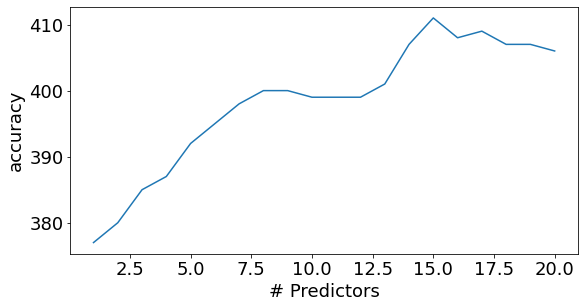

In [20]:
from sklearn.linear_model import LogisticRegression

# X = characters.drop(columns=["name","house","isAlive","house_alive_binned","house_alive","culture","house_alive1","house_alive2","house_alive3","house_alive4","house_alive5","house_alive6"])
# X_backup = characters.drop(columns=["name","house","isAlive","house_alive_binned","house_alive","culture","house_alive1","house_alive2","house_alive3","house_alive4","house_alive5","house_alive6"])
new_characters = characters
X = new_characters.drop(columns=["name","isAlive","house_alive_binned","house_alive","house"])
X_backup = new_characters.drop(columns=["name","isAlive","house_alive_binned","house_alive","house"])


#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    print('isAlive~' + '+'.join(predictor_subset))
    # model = sm.logit('isAlive~' + '+'.join(predictor_subset),data = characters).fit(method='bfgs')
    formula = 'isAlive~' + '+'.join(predictor_subset)
    accuracy, __, model = test(formula = 'isAlive~' + '+'.join(predictor_subset), num_examples = len(characters), cutoff=.5, clean_data=characters)
    # accuracy /= len(characters)
    # accuracy = model.aic
    return {"model":model, "accuracy":accuracy, "formula":formula}
    
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    print(models)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['accuracy'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

def forward_selection():
    models_best = pd.DataFrame(columns=["accuracy", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

models_best = forward_selection()
best_sub_plots()

In [22]:
models_best.loc[np.argmax(models_best.accuracy),"model"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                isAlive   No. Observations:                  493
Model:                          Logit   Df Residuals:                      478
Method:                           MLE   Df Model:                           14
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.3712
Time:                        13:29:34   Log-Likelihood:                -189.43
converged:                      False   LL-Null:                       -301.24
Covariance Type:            nonrobust   LLR p-value:                 7.905e-40
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.7643      0.460     -1.662      0.097      -1.666       0.137
culture_few_survive     -1.1462      0.622     -1.841      0.066      -2.366       0.074
house_alive1             0.7972      0.455      1.751      0.080      -0.095       1.689
male                    -0.7063      0.301     -2.347      0.019      -1.296      -0.116
boolDeadRelations       -1.0073      0.377     -2.671      0.008      -1.747      -0.268
popularity               2.0926      0.729      2.871      0.004       0.664       3.521
culture_none_survive    -1.6760      2.253     -0.744      0.457      -6.091       2.739
house_alive3             1.7173      0.450      3.813      0.000       0.834       2.600
culture_all_survive      2.6229      1.326      1.978      0.048       0.024       5.222
house_alive6             3.3201      0.952      3.486      0.000       1.454       5.187
house_alive2             0.5120      0.876      0.584      0.559      -1.205       2.229
house_alive4             1.3741      0.752      1.827      0.068      -0.100       2.848
culture_many_survive     0.5421      0.290      1.868      0.062      -0.027       1.111
house_alive7             5.6031      0.919      6.094      0.000       3.801       7.405
house_alive5             2.4450      0.495      4.936      0.000       1.474       3.416
========================================================================================
"""

In [27]:
# models_best.loc[np.argmax(models_best.accuracy),"formula"]
models_best

,accuracy,model
1,377,<statsmodels.discrete.discrete_model.BinaryRes...
2,380,<statsmodels.discrete.discrete_model.BinaryRes...
3,385,<statsmodels.discrete.discrete_model.BinaryRes...
4,387,<statsmodels.discrete.discrete_model.BinaryRes...
5,392,<statsmodels.discrete.discrete_model.BinaryRes...
6,395,<statsmodels.discrete.discrete_model.BinaryRes...
7,398,<statsmodels.discrete.discrete_model.BinaryRes...
8,400,<statsmodels.discrete.discrete_model.BinaryRes...
9,400,<statsmodels.discrete.discrete_model.BinaryRes...
10,399,<statsmodels.discrete.discrete_model.BinaryRes...


In [33]:
models_best.loc[np.argmax(models_best.accuracy),"accuracy"]#  / len(characters)
model = models_best.loc[15,"model"]
models_best.loc[15,"model"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                isAlive   No. Observations:                  493
Model:                          Logit   Df Residuals:                      477
Method:                           MLE   Df Model:                           15
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.3736
Time:                        13:36:05   Log-Likelihood:                -188.69
converged:                      False   LL-Null:                       -301.24
Covariance Type:            nonrobust   LLR p-value:                 1.615e-39
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.7400      0.466     -1.589      0.112      -1.653       0.173
culture_few_survive     -1.0560      0.628     -1.682      0.093      -2.287       0.175
house_alive1             0.9417      0.461      2.042      0.041       0.038       1.846
male                    -0.7138      0.303     -2.358      0.018      -1.307      -0.120
boolDeadRelations       -1.1858      0.481     -2.467      0.014      -2.128      -0.244
popularity               1.7501      0.778      2.249      0.025       0.225       3.275
culture_none_survive    -1.8133      2.337     -0.776      0.438      -6.394       2.767
house_alive3             1.6647      0.452      3.682      0.000       0.778       2.551
culture_all_survive      2.7994      1.423      1.967      0.049       0.010       5.588
house_alive6             3.6193      1.032      3.507      0.000       1.597       5.642
house_alive2             0.6415      0.871      0.736      0.461      -1.066       2.349
house_alive4             1.7594      0.785      2.241      0.025       0.220       3.299
culture_many_survive     0.4496      0.293      1.533      0.125      -0.125       1.024
house_alive7             5.3964      0.845      6.384      0.000       3.740       7.053
house_alive5             2.8024      0.517      5.422      0.000       1.789       3.816
numDeadRelations         0.0543      0.101      0.535      0.593      -0.145       0.253
========================================================================================
"""

In [35]:
model.resid

AttributeError: ignored

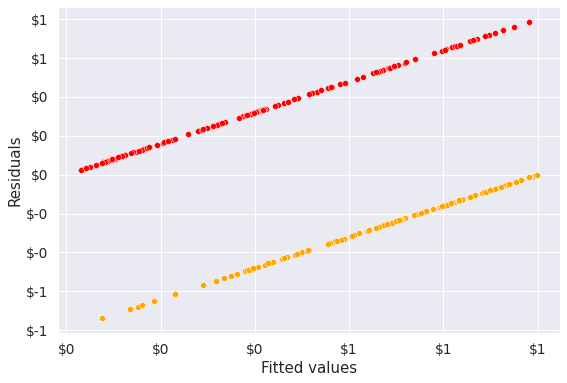

In [49]:
#Plotting residuals vs fitted values
plt.rcParams["figure.figsize"] = (9,6)
sns.set(font_scale=1.25)
alive = characters.loc[characters["isAlive"]==1]
dead = characters.loc[characters["isAlive"]==0]
resid = model.predict(characters) - characters["isAlive"]
ax = sns.scatterplot(x = model.predict(alive), y=model.predict(alive)-1,color = 'orange')
sns.scatterplot(x = model.predict(dead), y=model.predict(dead),color = 'red')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.xaxis.set_major_formatter('${x:,.0f}')

<AxesSubplot:ylabel='Count'>

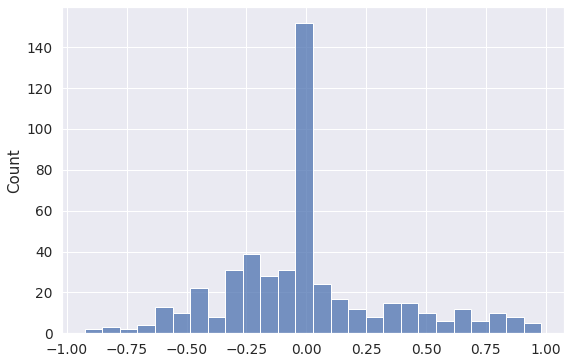

In [50]:
resid = model.predict(characters) - characters["isAlive"]
sns.histplot(resid)

In [32]:
411 / len(characters)

0.8336713995943205